In [1]:
import xarray as xr
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.animation import FuncAnimation

# Open the netcdf files

In [2]:
data_dir = "/Users/elischwat/Development/data/sublimationofsnow/lattice_boltzmann_rotors/ethan_output/output"

In [3]:
# List all files in the data directory
files = [f for f in os.listdir(data_dir) if f.endswith('.nc')]

# Function to extract timestep from filename
def extract_timestep(filename):
    # Assuming the timestep is the last 4 characters before the file extension
    return int(filename[-7:-3])

# Dictionary to store data with new time index
data_with_time_index = {}

# Process each file
for file in files:
    # Extract timestep
    timestep = extract_timestep(file)
    
    # Open the file
    file_path = os.path.join(data_dir, file)
    data = xr.open_dataset(file_path)
    
    # Create a new time index based on the timestep
    data = data.assign_coords(time=timestep)
    
    # Store the data
    data_with_time_index[file] = data

# Now data_with_time_index contains all the data with the new time index

In [4]:
output_dataset = xr.concat(data_with_time_index.values(), dim='time').sortby('time')

# Sort the data into a dataset that makes sense

In [5]:
# Select data where y=1 and y=2
u_data = output_dataset.sel(y=0).sel(r=0)
v_data = output_dataset.sel(y=1).sel(r=0)


In [6]:
vel_data = xr.merge([
    u_data.rename_vars(u='u'),
    v_data.rename_vars(u='v')
])

In [7]:
print(vel_data.isel(time=0).x.values.shape)
print(vel_data.isel(time=0).z.values.shape)
print(vel_data.isel(time=0).u.values.shape)
print(vel_data.isel(time=0).v.values.shape)
print()

(1024,)
(384,)
(384, 1024)
(384, 1024)



# Plot that ish

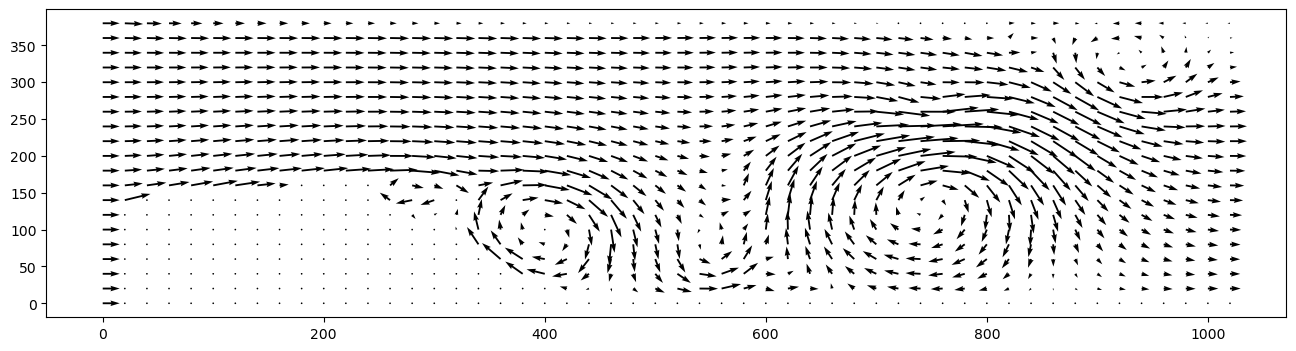

In [8]:
X, Z = np.meshgrid(vel_data.x.values, vel_data.z.values)

SKIP = 20
plt.figure(figsize=(16,4))
plt.quiver(
    X[::SKIP, ::SKIP],
    Z[::SKIP, ::SKIP],
    vel_data.isel(time=0).u.values[::SKIP, ::SKIP],
    vel_data.isel(time=0).v.values[::SKIP, ::SKIP],
    scale=1000,
    width=0.0015
)

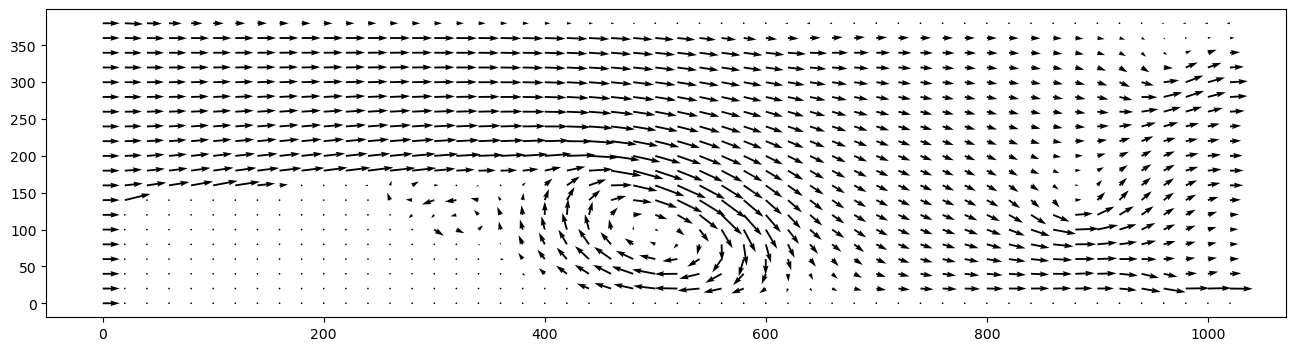

In [9]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(16,4))

# Initialize the quiver plot
quiver = ax.quiver(
    X[::SKIP, ::SKIP],
    Z[::SKIP, ::SKIP],
    vel_data.isel(time=0).u.values[::SKIP, ::SKIP],
    vel_data.isel(time=0).v.values[::SKIP, ::SKIP],
    scale=1000,
    width=0.0015
)

# Define the update function
def update(frame):
    u = vel_data.isel(time=frame).u.values[::SKIP, ::SKIP]
    v = vel_data.isel(time=frame).v.values[::SKIP, ::SKIP]
    quiver.set_UVC(u, v)
    return quiver,

# Create the animation
anim = FuncAnimation(fig, update, frames=len(vel_data.time), blit=True)

# Save the animation as a video file
anim.save('doppler_lidar_scan.mp4', writer='ffmpeg')

plt.show()

# Simulate doppler lidar scan!

Place the radar at x = 800, z = 0. Iterate at elevation angles of 1˚, at range-intervals of 15m.

In [10]:
vel_data_one_frame = vel_data.isel(time=0)

In [11]:
vel_data_one_frame = vel_data_one_frame.assign_coords({"x": (vel_data_one_frame.x - 800).values})
vel_data_one_frame = vel_data_one_frame.assign_coords({"z": (vel_data_one_frame.z).values})

Show the dataset we will convert to a simulated DL scan

(0.0, 350.0)

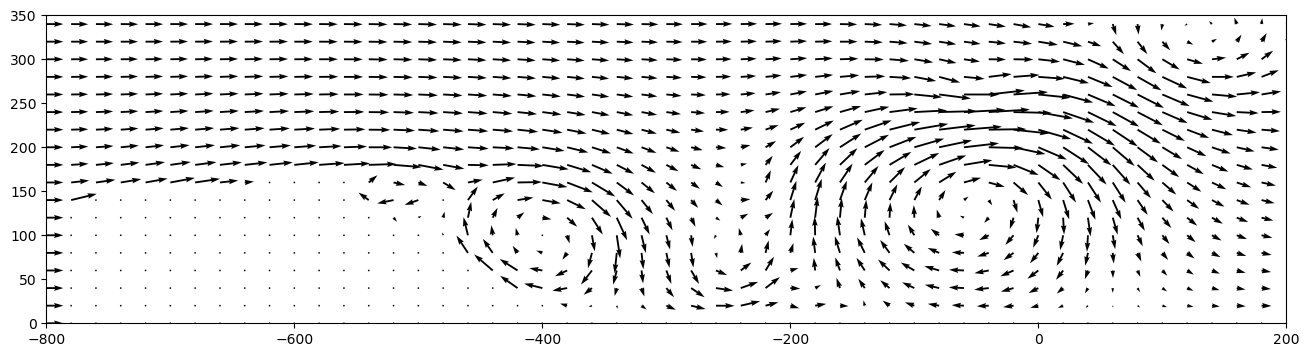

In [12]:
X, Z = np.meshgrid(vel_data_one_frame.x.values, vel_data_one_frame.z.values)

SKIP = 20
plt.figure(figsize=(16,4))
plt.quiver(
    X[::SKIP, ::SKIP],
    Z[::SKIP, ::SKIP],
    vel_data_one_frame.u.values[::SKIP, ::SKIP],
    vel_data_one_frame.v.values[::SKIP, ::SKIP],
    scale=1000,
    width=0.0015
)
plt.xlim(-800, 200)
plt.ylim(0, 350)

Simulate the scan

In [13]:
# define function for converting from radial to polar coordinates
# remember: WE GO COUNTERCLOCKWISE FROM 0˚ on the unit circle

In [14]:
def cartesian_convert(elevation,range):
    x = range*np.cos(np.deg2rad(elevation))
    y = range*np.sin(np.deg2rad(elevation))
    return x, y

In [15]:
us = []
vs = []
df = []
# iterate over elevation values and range values
for elevation in np.linspace(0,180, 181):
    for range in np.linspace(0,600, 101):
        x, z = cartesian_convert(elevation, range)
        u = vel_data_one_frame.u.interp(x=x, z=z, method='linear')
        v = vel_data_one_frame.v.interp(x=x, z=z, method='linear')
        df.append({
            'u'         : u.values.item(),
            'v'         : v.values.item(),
            'elevation' : elevation,
            'range'     : range,
        })

In [16]:
df = pd.DataFrame(df)

df['r_velu'] = df['u']*np.cos(np.deg2rad(elevation))
df['r_velv'] = df['v']*np.cos(np.deg2rad(90 - elevation))
df['r_vel'] = df['r_velu'] + df['r_velv']

Open up an actual scan, mimic plotting from another notebok

In [17]:
actual_scan_file = '/Users/elischwat/Development/data/sublimationofsnow/gucdlrhiM1.b1/gucdlrhiM1.b1.20230418.234834.cdf'


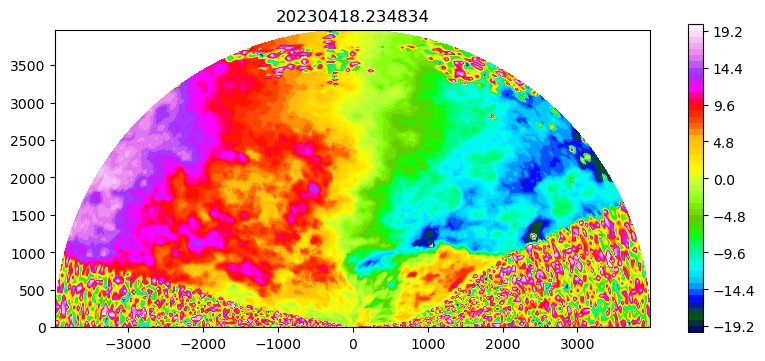

In [18]:
actual_scan_ds = xr.open_dataset(actual_scan_file)
actual_scan_ds['x'] = actual_scan_ds['range']*np.cos(np.deg2rad(actual_scan_ds['elevation']))
actual_scan_ds['z'] = actual_scan_ds['range']*np.sin(np.deg2rad(actual_scan_ds['elevation']))
src = actual_scan_ds.sel(range=slice(0,4000))
plt.subplots(figsize=(9.6, 4))
plt.contourf(
    src['x'].values.T, src['z'].values.T,
    src['radial_velocity'].values,
    cmap='gist_ncar',
    levels=50
)
plt.colorbar()
plt.gca().set_aspect('equal')
name = actual_scan_file.split('gucdlrhiM1.b1/gucdlrhiM1.b1.')[1][:-4]
plt.title(name)
plt.show()

In [19]:
src['x'] =  - src['x']

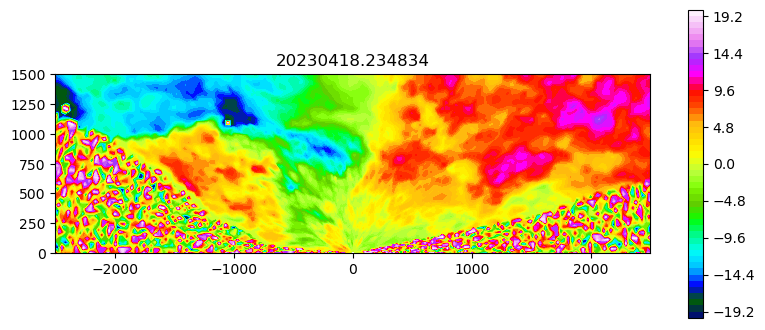

In [20]:
plt.subplots(figsize=(9.6, 4))
plt.contourf(
    src['x'].values.T, src['z'].values.T,
    src['radial_velocity'].values,
    cmap='gist_ncar',
    levels=50,
    vmin=-20,
    vmax=20
)

plt.gca().set_aspect('equal')
name = actual_scan_file.split('gucdlrhiM1.b1/gucdlrhiM1.b1.')[1][:-4]
plt.title(name)
plt.xlim(-2500,2500)
plt.ylim(0,1500)
plt.colorbar()
plt.show()


In [21]:
x,z = cartesian_convert(df['elevation'], df['range'])
df['x'] = x
df['z'] = z

In [22]:
df = df.set_index(['x', 'z'])

In [23]:
ds = df[~df.index.duplicated()].to_xarray()

In [24]:
df = ds.to_dataframe().dropna()

(0.0, 350.0)

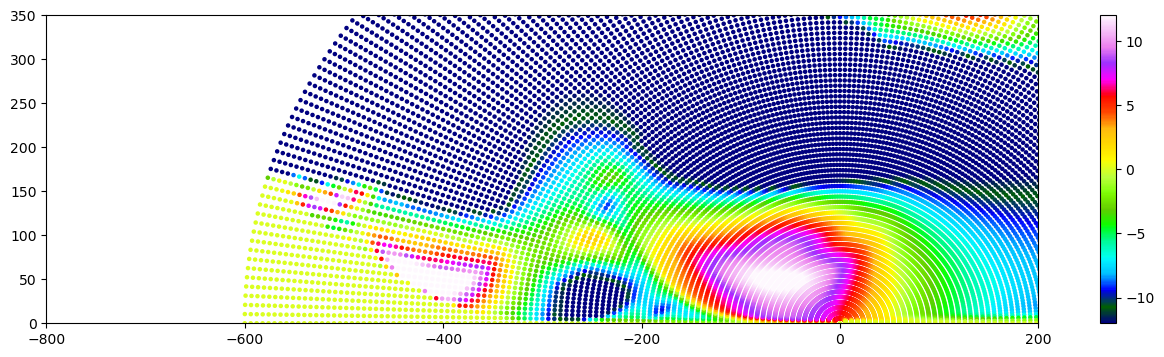

In [37]:
plt.figure(figsize=(16,4))
plt.scatter(
    df.reset_index().x,
    df.reset_index().z,
    c = df.reset_index().r_vel,
    cmap='gist_ncar',
    vmin=-12,
    vmax=12,
    s=5
)
plt.colorbar()

plt.xlim(-800, 200)
plt.ylim(0, 350)

In [28]:
ds = df.to_xarray()
ds

<xarray.Dataset> Size: 7GB
Dimensions:    (x: 12508, z: 10158)
Coordinates:
  * x          (x) float64 100kB -600.0 -599.9 -599.6 ... 222.8 222.9 223.0
  * z          (z) float64 81kB 7.348e-14 10.47 20.94 31.4 ... 72.31 200.7 104.0
Data variables:
    u          (x, z) float64 1GB 0.0 nan nan nan nan ... nan nan nan nan 9.185
    v          (x, z) float64 1GB 0.0 nan nan nan nan ... nan nan nan -0.1254
    elevation  (x, z) float64 1GB 180.0 nan nan nan nan ... nan nan nan nan 25.0
    range      (x, z) float64 1GB 600.0 nan nan nan nan ... nan nan nan 246.0
    r_velu     (x, z) float64 1GB -0.0 nan nan nan nan ... nan nan nan -9.185
    r_velv     (x, z) float64 1GB 0.0 nan nan nan nan ... nan nan nan -7.681e-18
    r_vel      (x, z) float64 1GB 0.0 nan nan nan nan ... nan nan nan nan -9.185

# WHY WONT CONTOURF PLOT WORK???

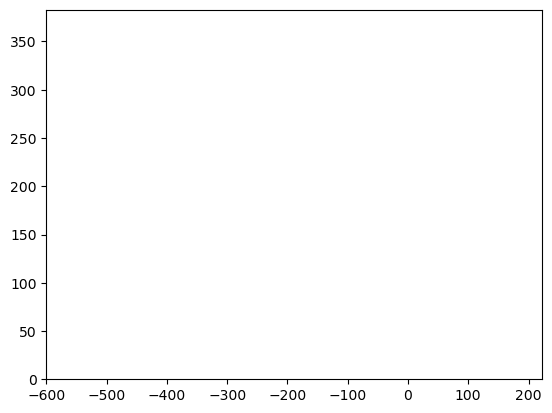

In [29]:
X, Z = np.meshgrid(ds.x, ds.z)
X, Z = np.meshgrid(ds.x, ds.z)
plt.contourf(
    X.T, Z.T, 
    ds['r_vel'].values,
    cmap='gist_ncar',
    levels=50,
    vmin=-20,
    vmax=20
    
)